#  What kind of films should our company create?

## Overview

This project explores what types of movies are the most successful according to the box office. With our company planning to enter the film production market, we use real-world data from Box Office Mojo, IMDb, and The Movie Data Base to identify trends in movie genre, ratings, and  that can guide our production strategy.

## Business Understanding

### Business Problem
The company is launching a new movie studio but has no prior experience in film production. To compete in this market we need to make data backed decisions about what types of movies are likely to succeed.

### Business Questions
- What genres earn the most revenue?
- Do highly rated movies (IMDb / The Movie Data Base) earn more?
- What rating leads to higher box office performance?

### Objective
Analyze film data from major sources to identify key success factors and make three data-driven recommendations for profitable film production.


In [2]:
# Imports here
# Imports here
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Visual settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Data Understanding

We will use three datasets from trusted industry sources:

1. **Box Office Mojo** : Domestic gross revenue by movie (`bom.movie_gross.csv.gz`)
2. **IMDb** : Movie metadata including genres, release year, IMDb rating, and vote count (`im.db`)
3. **The Movie Data Base** : Critic and audience scores by title (`tmdb.movies.csv.gz`)

We’ll merge them using lowercase titles and release year.

In [15]:
# Load Box Office Mojo
bom = pd.read_csv("data/bom.movie_gross.csv.gz")
print("Box Office Mojo data shape:", bom.shape)
bom.head()

Box Office Mojo data shape: (3387, 5)


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [4]:
# Load TMDB CSV
tmdb = pd.read_csv("data/tmdb.movies.csv.gz")

# Clean title and extract year
tmdb["title"] = tmdb["title"].str.lower().str.strip()
tmdb["release_year"] = pd.to_datetime(tmdb["release_date"], errors="coerce").dt.year

# Keep only useful columns
tmdb_clean = tmdb[["title", "release_year", "vote_average", "vote_count", "popularity"]].dropna()

tmdb_clean.head()

,title,release_year,vote_average,vote_count,popularity
0,harry potter and the deathly hallows: part 1,2010,7.7,10788,33.533
1,how to train your dragon,2010,7.7,7610,28.734
2,iron man 2,2010,6.8,12368,28.515
3,toy story,1995,7.9,10174,28.005
4,inception,2010,8.3,22186,27.920


In [16]:
# Connect to the IMDb database file
conn = sqlite3.connect("data/imm.db/im.db")

# List all tables in the database
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
display(tables)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [20]:
# Load the movie_basics and movie_ratings tables
basics = pd.read_sql("SELECT * FROM movie_basics;", conn)
ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)

print("movie_basics shape:", basics.shape)
print("movie_ratings shape:", ratings.shape)
basics.head()

movie_basics shape: (146144, 6)
movie_ratings shape: (73856, 3)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


## Data Preparation

We performe the following steps:
- Converte revenue fields to numeric format
- Extract release year from release date
- Lowercase and strip titles for consistent merging
- Merge the three datasets on title and release year
- Simplify genre categories by taking the first listed genre
- Drop rows with missing values in key fields

### Clean the Box Office Mojo data

In [7]:
# Drop missing domestic gross and clean formatting
bom_clean = bom[bom["domestic_gross"].notnull()].copy()
bom_clean["domestic_gross"] = bom_clean["domestic_gross"].replace(r'[\$,]', '', regex=True).astype(float)

# Clean title and preserve the existing year
bom_clean["title"] = bom_clean["title"].str.lower().str.strip()
bom_clean["release_year"] = bom_clean["year"]

# Keep relevant columns
bom_clean = bom_clean[["title", "release_year", "domestic_gross"]]
bom_clean.head()

,title,release_year,domestic_gross
0,toy story 3,2010,415000000.0
1,alice in wonderland (2010),2010,334200000.0
2,harry potter and the deathly hallows part 1,2010,296000000.0
3,inception,2010,292600000.0
4,shrek forever after,2010,238700000.0


### Clean IMDB data

In [8]:
# Clean title and year columns in basics
basics_clean = basics.rename(columns={
    "primary_title": "title",
    "start_year": "release_year"
})

# Keep only relevant columns
basics_clean = basics_clean[["movie_id", "title", "release_year", "genres"]].copy()

# Lowercase titles
basics_clean["title"] = basics_clean["title"].str.lower().str.strip()

# Merge IMDb ratings into basics
imdb_clean = basics_clean.merge(ratings, on="movie_id", how="left")

# Preview
imdb_clean.head()

,movie_id,title,release_year,genres,averagerating,numvotes
0,tt0063540,sunghursh,2013,"Action,Crime,Drama",7.0,77.0
1,tt0066787,one day before the rainy season,2019,"Biography,Drama",7.2,43.0
2,tt0069049,the other side of the wind,2018,Drama,6.9,4517.0
3,tt0069204,sabse bada sukh,2018,"Comedy,Drama",6.1,13.0
4,tt0100275,the wandering soap opera,2017,"Comedy,Drama,Fantasy",6.5,119.0


In [23]:
# Merge Box Office Mojo with IMDb
bom_imdb = bom_clean.merge(imdb_clean, on=["title", "release_year"], how="inner")
print("After merging BOM + IMDb:", bom_imdb.shape)
bom_imdb.head()

After merging BOM + IMDb: (1936, 7)


,title,release_year,domestic_gross,movie_id,genres,averagerating,numvotes
0,toy story 3,2010,415000000.0,tt0435761,"Adventure,Animation,Comedy",8.3,682218.0
1,inception,2010,292600000.0,tt1375666,"Action,Adventure,Sci-Fi",8.8,1841066.0
2,shrek forever after,2010,238700000.0,tt0892791,"Adventure,Animation,Comedy",6.3,167532.0
3,the twilight saga: eclipse,2010,300500000.0,tt1325004,"Adventure,Drama,Fantasy",5.0,211733.0
4,iron man 2,2010,312400000.0,tt1228705,"Action,Adventure,Sci-Fi",7.0,657690.0


In [24]:
# Merge BOM+IMDb with TMDB
full_df = bom_imdb.merge(tmdb_clean, on=["title", "release_year"], how="inner")
print("After merging with TMDB:", full_df.shape)
full_df.head()

After merging with TMDB: (1821, 10)


,title,release_year,domestic_gross,movie_id,genres,averagerating,numvotes,vote_average,vote_count,popularity
0,toy story 3,2010,415000000.0,tt0435761,"Adventure,Animation,Comedy",8.3,682218.0,7.7,8340,24.445
1,inception,2010,292600000.0,tt1375666,"Action,Adventure,Sci-Fi",8.8,1841066.0,8.3,22186,27.920
2,shrek forever after,2010,238700000.0,tt0892791,"Adventure,Animation,Comedy",6.3,167532.0,6.1,3843,15.041
3,the twilight saga: eclipse,2010,300500000.0,tt1325004,"Adventure,Drama,Fantasy",5.0,211733.0,6.0,4909,20.340
4,iron man 2,2010,312400000.0,tt1228705,"Action,Adventure,Sci-Fi",7.0,657690.0,6.8,12368,28.515


In [25]:
# Drop missing critical columns
full_df = full_df.dropna(subset=[
    "domestic_gross", 
    "averagerating", 
    "vote_average", 
    "genres"
])

# Extract the primary genre
full_df.loc[:, "main_genre"] = full_df["genres"].str.split(",").str[0]

# Reset index for cleanliness
full_df.reset_index(drop=True, inplace=True)

# Preview the final merged dataset
full_df[[
    "title", "release_year", "main_genre", "domestic_gross",
    "averagerating", "vote_average", "popularity"
]].head()

,title,release_year,main_genre,domestic_gross,averagerating,vote_average,popularity
0,toy story 3,2010,Adventure,415000000.0,8.3,7.7,24.445
1,inception,2010,Action,292600000.0,8.8,8.3,27.920
2,shrek forever after,2010,Adventure,238700000.0,6.3,6.1,15.041
3,the twilight saga: eclipse,2010,Adventure,300500000.0,5.0,6.0,20.340
4,iron man 2,2010,Action,312400000.0,7.0,6.8,28.515


## Analysis and Results

We used exploratory data analysis (EDA) to uncover patterns between movie revenue and other characteristics such as genre, ratings, and popularity. These insights will directly inform which kinds of films our studio should prioritize producing.

We used the following three guiding business questions:
1. What genres earn the most at the box office?
2. Are higher-rated movies more profitable?
3. Does online popularity predict box office success?

Each question is addressed with a visualization and a corresponding recommendation.

### What genres earn the most?

We calculated the average domestic box office revenue by primary genre.

C:\Users\surpr\AppData\Local\Temp\ipykernel_9132\246119228.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_revenue.index, y=genre_revenue.values, palette="viridis")


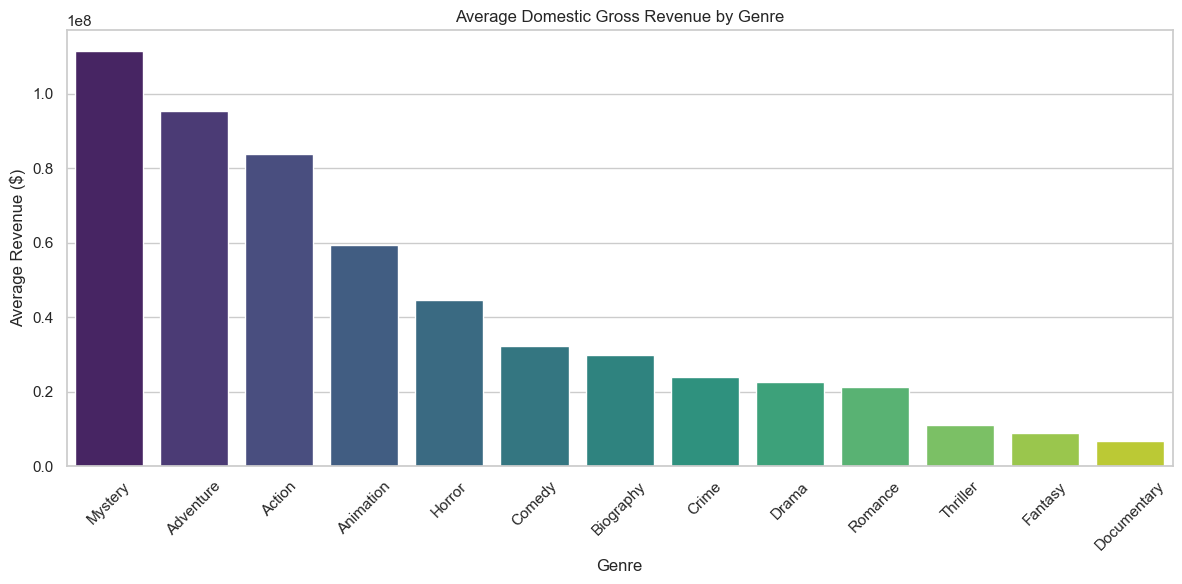

In [26]:
genre_revenue = full_df.groupby("main_genre")["domestic_gross"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_revenue.index, y=genre_revenue.values, palette="viridis")
plt.title("Average Domestic Gross Revenue by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Revenue ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We notice that mystery, adventure, action, animation and horror generate the most revenue.

### 2. Are better-rated movies more profitable?

We examined the relationship between IMDb user ratings and box office revenue.

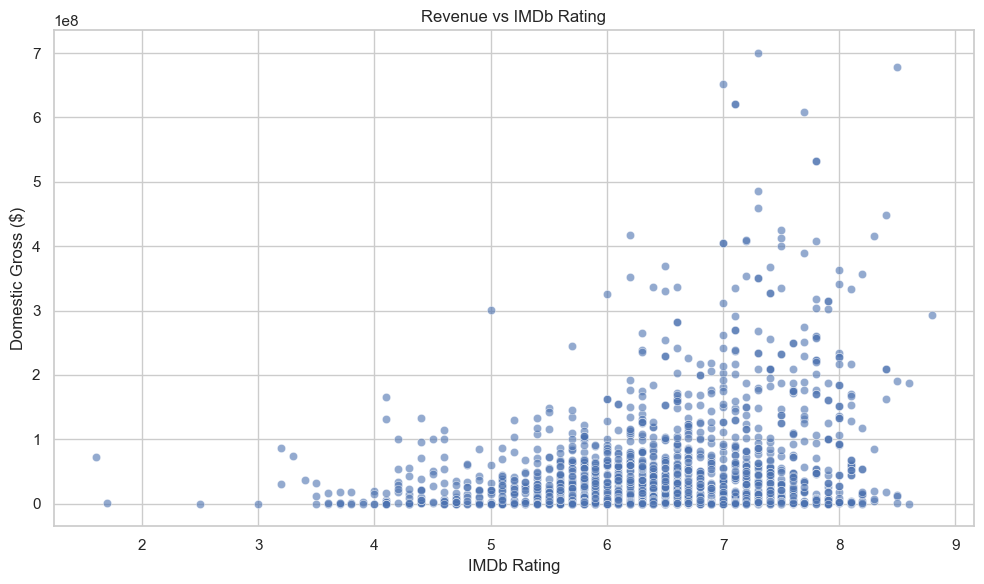

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=full_df, x="averagerating", y="domestic_gross", alpha=0.6)
plt.title("Revenue vs IMDb Rating")
plt.xlabel("IMDb Rating")
plt.ylabel("Domestic Gross ($)")
plt.tight_layout()
plt.show()

### 3. Does popularity on TMDB predict box office success?

We used TMDB’s popularity score to gauge audience interest before release.

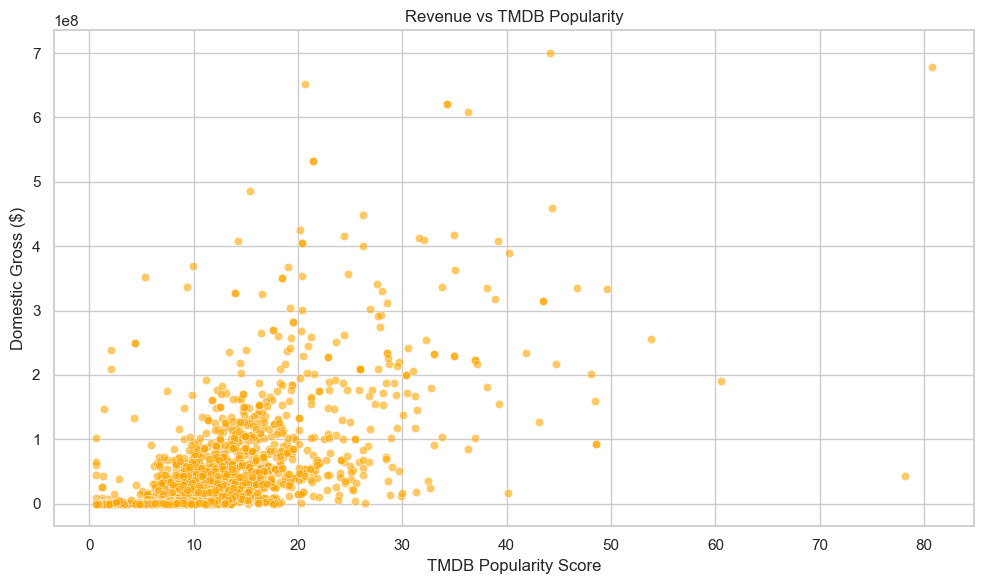

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=full_df, x="popularity", y="domestic_gross", alpha=0.6, color="orange")
plt.title("Revenue vs TMDB Popularity")
plt.xlabel("TMDB Popularity Score")
plt.ylabel("Domestic Gross ($)")
plt.tight_layout()
plt.show()

We can conclude that popularity does not totally equate box office success. Thus some type of movies might be worth making even when they do not seem praised by the public. 

### Business Recommendation 1

Prioritize genres like mystery, adventure, action, animation and horror for your first few films. These genres consistently bring in higher average revenue and appeal to large global audiences.

### Business Recommendation 2

Aim for high-quality films. Movies with IMDb ratings above 7 tend to earn more at the box office. Focus on strong scripts, experienced directors, and market testing.

### Business Recommendation 3

Use pre-release marketing to build TMDB buzz. Movies with higher popularity scores tend to perform better at the box office, signaling that online interest can be a leading indicator of commercial success.

## Conclusion

By analyzing real-world data from Box Office Mojo, IMDb, and TMDB, we’ve identified clear trends that can guide the launch of our new movie studio.

Movies in genres like mystery, adventure, action, animation and horror consistently outperform others in box office revenue.

Higher IMDb ratings correlate with strong financial performance, reinforcing the importance of producing high-quality films. 

TMDB popularity scores are predictive of commercial success, highlighting the role of pre-release engagement.

Together, these insights give us a data-backed foundation for reducing risk and increasing our chances of producing a hit.


## Next Steps

To further refine our film strategy, we recommend:

-  **Incorporating Budget Data:** Use production budgets to calculate return on investment (ROI), not just revenue.
-  **Analyzing International Performance:** Include foreign box office data to target global markets.
-  **Exploring Seasonal Trends:** Determine optimal release months based on genre and past box office timing.
-  **Building a Pre-Greenlight Scoring Model:** Create a simple model to score new movie ideas based on genre, projected rating, and potential popularity.

These additions will help us reduce risk and maximize profitability as the studio grows.
